In [96]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import copy
def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        return image_data.reshape((num_images, rows, cols))

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        label_data = np.frombuffer(f.read(), dtype=np.uint8)
        return label_data


In [97]:
train_images = load_images('data/train-images.idx3-ubyte')
train_labels = load_labels('data/train-labels.idx1-ubyte')

test_images = load_images('data/t10k-images.idx3-ubyte')
test_labels = load_labels('data/t10k-labels.idx1-ubyte')


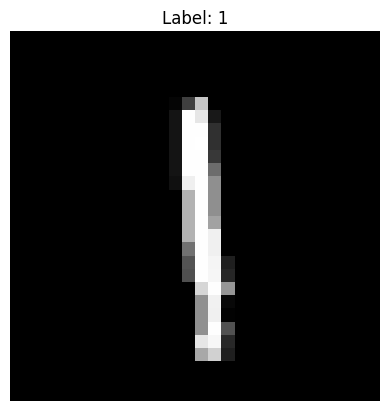

In [113]:
def show_image(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# Example: show the 5th training image
show_image(train_images[8], train_labels[8])

In [99]:
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [100]:
def ReLU(z):
    return np.maximum(0,z)

In [101]:
def ReLU_derivative(z):
    return (z > 0).astype(np.float32)



In [102]:
def softmax(Z):
    """
    Z: np.ndarray of shape (num_classes, m)
    Returns: softmax probabilities of same shape
    """
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)  # for numerical stability
    exp_Z = np.exp(Z_shifted)
    softmax_output = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    return softmax_output

In [103]:
def one_hot_encode(y_labels, num_classes=10):
    m = y_labels.shape[0]
    one_hot = np.zeros((num_classes, m))
    one_hot[y_labels, np.arange(m)] = 1
    return one_hot


In [104]:
def initialize_paras(n_x, nh1, nh2, outL):
    W1 = np.random.randn(128, 784) * np.sqrt(2. / 784)
    W2 = np.random.randn(64, 128) * np.sqrt(2. / 128)
    W3 = np.random.randn(10, 64) * np.sqrt(2. / 64)
    b1 = np.random.rand(nh1, 1)
    b2 = np.random.rand(nh2,1)
    b3 = np.random.rand(outL,1)

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    return parameters


In [105]:
def forward_prop(X, parameters):

    W1 = parameters["W1"]
    b1 = parameters["b1"]

    W2 = parameters["W2"]
    b2 = parameters["b2"]

    W3 = parameters["W3"]
    b3 = parameters["b3"]

    Z1 = W1 @ X + b1
    A1 = ReLU(Z1)

    Z2 = W2 @ A1 + b2
    A2 = ReLU(Z2)

    Z3 =  W3 @ A2 + b3
    A3 = softmax(Z3)

    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2,
        "Z3": Z3,
        "A3": A3
    }

    return A3, cache



In [106]:
def cost_function(A3, Y):
    epsilon = 1e-15
    A3_clipped = np.clip(A3, epsilon, 1 - epsilon)
    #Y is one hot encoded
    loss = -np.mean(np.sum(Y * np.log(A3_clipped), axis=0))
    return loss



In [107]:
def backward_prop(parameters, cache, X, Y):
    m = X.shape[1]
    W1 = parameters["W1"]
    b1 = parameters["b1"]

    W2 = parameters["W2"]
    b2 = parameters["b2"]

    W3 = parameters["W3"]
    b3 = parameters["b3"]

    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    Z3 = cache["Z3"]

    A1 = cache["A1"]
    A2 = cache["A2"]
    A3 = cache["A3"]


    dZ3 = A3 - Y
    dW3 = (1/m) * (dZ3 @ A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = W3.T @ dZ3
    dZ2 = dA2 * ReLU_derivative(Z2)
    dW2 = (1/m) * (dZ2 @ A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = W2.T @ dZ2
    dZ1 = dA1 * ReLU_derivative(Z1)
    dW1 = (1/m) * (dZ1 @ X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2,
        "dW3": dW3,
        "db3": db3
    }

    return grads


In [108]:
def update_parameters(parameters, grads, learning_rate= 0.1):
    deep_parameter = copy.deepcopy(parameters)

    W1 = deep_parameter["W1"]
    b1 = deep_parameter["b1"]
    W2 = deep_parameter["W2"]
    b2 = deep_parameter["b2"]
    W3 = deep_parameter["W3"]
    b3 = deep_parameter["b3"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    dW3 = grads["dW3"]
    db3 = grads["db3"]

    W1 -= learning_rate*dW1
    b1 -= learning_rate*db1
    W2 -= learning_rate*dW2
    b2 -= learning_rate*db2
    W3 -= learning_rate*dW3
    b3 -= learning_rate*db3

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters



In [109]:

def nn_model(X, Y, num_iterations = 10000, print_cost=False):
    parameters = initialize_paras(784, 128, 64, 10)
    for i in range(0, num_iterations):
        A3, cache = forward_prop(X, parameters)
        cost = cost_function(A3, Y)
        grads = backward_prop(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate= 1.0)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters
    

In [110]:
def predict(parameters, X):
    A3, cache = forward_prop(X,parameters)
    predictions = np.argmax(A3, axis= 0)
    return predictions

In [111]:
X = train_images.reshape(train_images.shape[0], -1).T
X = X.astype(np.float32) / 255.0

Y = one_hot_encode(train_labels)

model = nn_model(X,Y,10)

In [112]:
X_test = test_images.reshape(-1, 28*28).T.astype(np.float32) / 255.0
Y_test = one_hot_encode(test_labels)

preds = predict(model,X_test)
print("Test accuracy:", np.mean(preds == test_labels) * 100, "%")

Test accuracy: 10.09 %
